# Process the gravity data



In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from fatiando.gravmag import normal_gravity, tesseroid
from fatiando.mesher import Tesseroid
from fatiando import gridder
from load_icgem import load_icgem_gdf

In [3]:
datapath = 'data/{}'
gravfile = 'go_cons_gcf_2_tim_r5-africa-1deg.gdf'
topofile = 'etopo1-africa-1deg.gdf'
topoexpfile = 'etopo1-africa-1deg-expanded.gdf'

## The raw gravity data

In [4]:
data = load_icgem_gdf(datapath.format(gravfile))

In [5]:
data.keys()

['area',
 'longitude',
 'height',
 'shape',
 'gridstep',
 'latitude',
 'gravity_ell',
 'metadata']

In [6]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2016/07/12
        product_type     gravity_field
                body     earth
           modelname     go_cons_gcf_2_tim_r5
     max_used_degree           280
         tide_system     tide_free
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       40.000000000000    
      latlimit_south      -40.000000000000    
      longlimit_west      -20.000000000000    
      longlimit_east       55.000000000000    
            gridstep       1.0000000000000    
     height_over_ell       4000.0000 m
  latitude_parallels            81
 longitude_parallels            76
number_of_gridpoints       

In [7]:
lat = data['latitude']
lon = data['longitude']
height = data['height']
grav = data['gravity_ell']
shape = data['shape']
area = data['area']

In [8]:
print(area)

[-40.0, 40.0, -20.0, 55.0]


To choose colormaps:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://matplotlib.org/users/colormaps.html

(-20.0, 55.0)

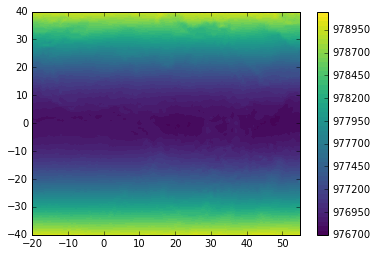

In [9]:
plt.figure()
plt.tricontourf(lon, lat, grav, 50, cmap='viridis')
plt.colorbar()
plt.xlim(area[2], area[3])

## Calculate the disturbance

In [10]:
gammap = normal_gravity.gamma_closed_form(lat, height)

(-20.0, 55.0)

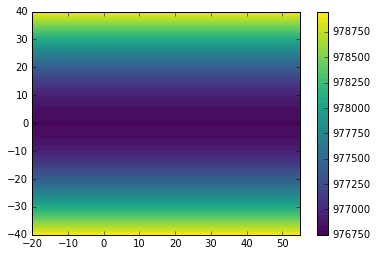

In [11]:
plt.figure()
plt.tricontourf(lon, lat, gammap, 50, cmap='viridis')
plt.colorbar()
plt.xlim(area[2], area[3])

The disturbance is the difference between the observed gravity and the normal gravity at the same point:

$$
\delta(P) = g(P) - \gamma(P)
$$

In [12]:
disturbance = grav - gammap

(-20.0, 55.0)

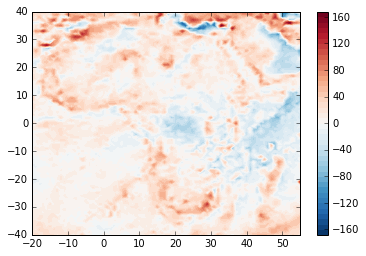

In [13]:
plt.figure()
plt.tricontourf(lon, lat, disturbance, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

## Calculate the simple Bouguer anomaly

In [14]:
etopo = load_icgem_gdf(datapath.format(topofile))

In [15]:
etopo.keys()

['area',
 'longitude',
 'shape',
 'topography_grd',
 'gridstep',
 'latitude',
 'metadata']

In [16]:
topo = etopo['topography_grd']

(-20.0, 55.0)

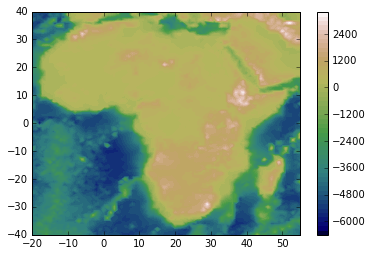

In [17]:
plt.figure()
plt.tricontourf(lon, lat, topo, 50, cmap='gist_earth')
plt.colorbar()
plt.xlim(area[2], area[3])

In [18]:
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

(-20.0, 55.0)

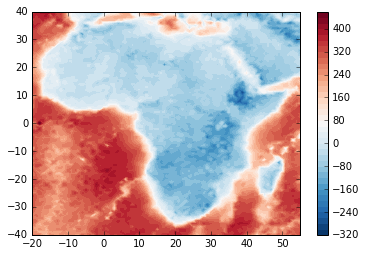

In [19]:
plt.figure()
plt.tricontourf(lon, lat, bouguer, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

## Complete Bouguer

In [23]:
etopoexp = load_icgem_gdf(datapath.format(topoexpfile))

In [24]:
step = etopoexp['gridstep']
print('Grid spacing:', step)
latexp = etopoexp['latitude']
lonexp = etopoexp['longitude']
topoexp = etopoexp['topography_grd']

Grid spacing: 1.0


In [34]:
def modelgen(lat, lon, topo, step):
    for i in range(topo.size):
        if topo[i] >= 0:
            t = Tesseroid(w=lon[i] - step/2,
                          e=lon[i] + step/2,
                          s=lat[i] - step/2,
                          n=lat[i] + step/2,
                          top=topo[i],
                          bottom=0,
                          props={'density': 2670})
        else:
            t = Tesseroid(w=lon[i] - step/2,
                          e=lon[i] + step/2,
                          s=lat[i] - step/2,
                          n=lat[i] + step/2,
                          top=0,
                          bottom=topo[i],
                          props={'density': 1040 - 2670})        
        yield t

In [37]:
%%time
modelo = modelgen(latexp, lonexp, topoexp, step)
topo_effect = tesseroid.gzz(lon, lat, height, modelo)

CPU times: user 48.3 s, sys: 64 ms, total: 48.4 s
Wall time: 48.1 s


In [38]:
bouguer_full = disturbance - topo_effect

(-20.0, 55.0)

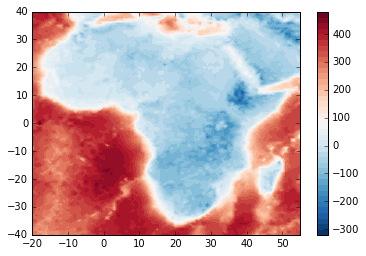

In [39]:
plt.figure()
plt.tricontourf(lon, lat, bouguer_full, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

## Bouguer vs equivalent topography

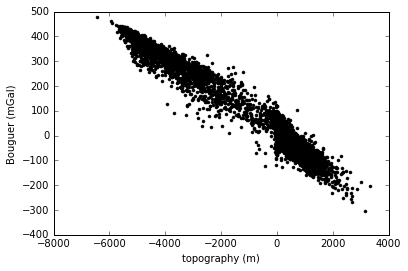

In [40]:
plt.figure()
plt.plot(topo, bouguer_full, '.k')
plt.xlabel('topography (m)')
plt.ylabel('Bouguer (mGal)')

In [41]:
rhoa = 1040
rhoc = 2670

In [42]:
topo_eq = np.copy(topo)
topo_eq[topo < 0] = topo[topo < 0]*(rhoc - rhoa)/rhoc
print(topo_eq)

[-2194.08988764 -2076.87640449 -2142.80898876 ...,   -17.09363296   280.
   177.        ]


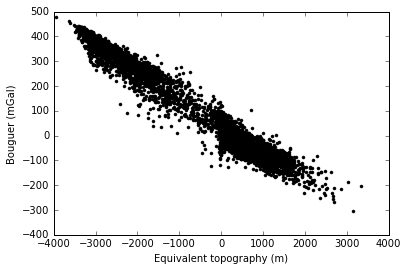

In [43]:
plt.figure()
plt.plot(topo_eq, bouguer_full, '.k')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

In [51]:
a, b = sp.polyfit(topo_eq, bouguer_full, deg=1)
print(a, b)

-0.114507931584 31.8249485678


In [52]:
reta = a*topo_eq + b

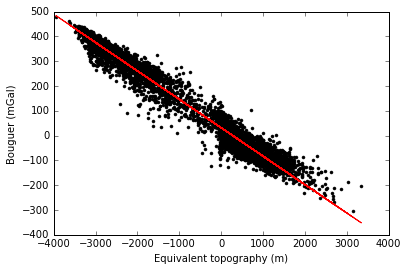

In [53]:
plt.figure()
plt.plot(topo_eq, bouguer_full, '.k')
plt.plot(topo_eq, reta, '-r')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

In [54]:
bg_raiz = reta

(-20.0, 55.0)

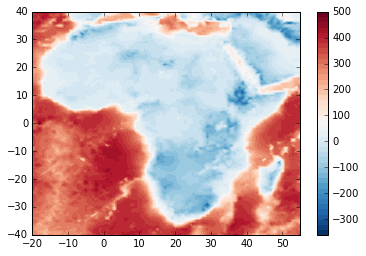

In [55]:
plt.figure()
plt.tricontourf(lon, lat, bg_raiz, 50, cmap='RdBu_r')
plt.colorbar()
plt.xlim(area[2], area[3])

In [56]:
bg_crustal = bouguer_full - bg_raiz

(-20.0, 55.0)

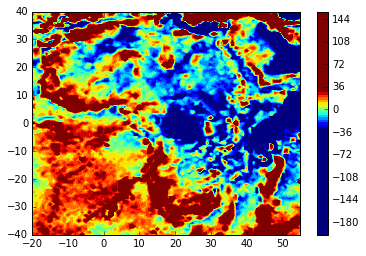

In [57]:
plt.figure()
plt.tricontourf(lon, lat, bg_crustal, 100, cmap='jet', vmin=-30, vmax=30)
plt.colorbar()
plt.xlim(area[2], area[3])